<a href="https://colab.research.google.com/github/muxair080/Human-Action-Recognition/blob/main/Action_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d vineethakkinapalli/ucf50-action-recognition-dataset

100% 3.03G/3.04G [00:28<00:00, 96.6MB/s]
100% 3.04G/3.04G [00:28<00:00, 115MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/ucf50-action-recognition-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install youtube_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00


In [ ]:
import pafy

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Pick 20 random Categories from the data

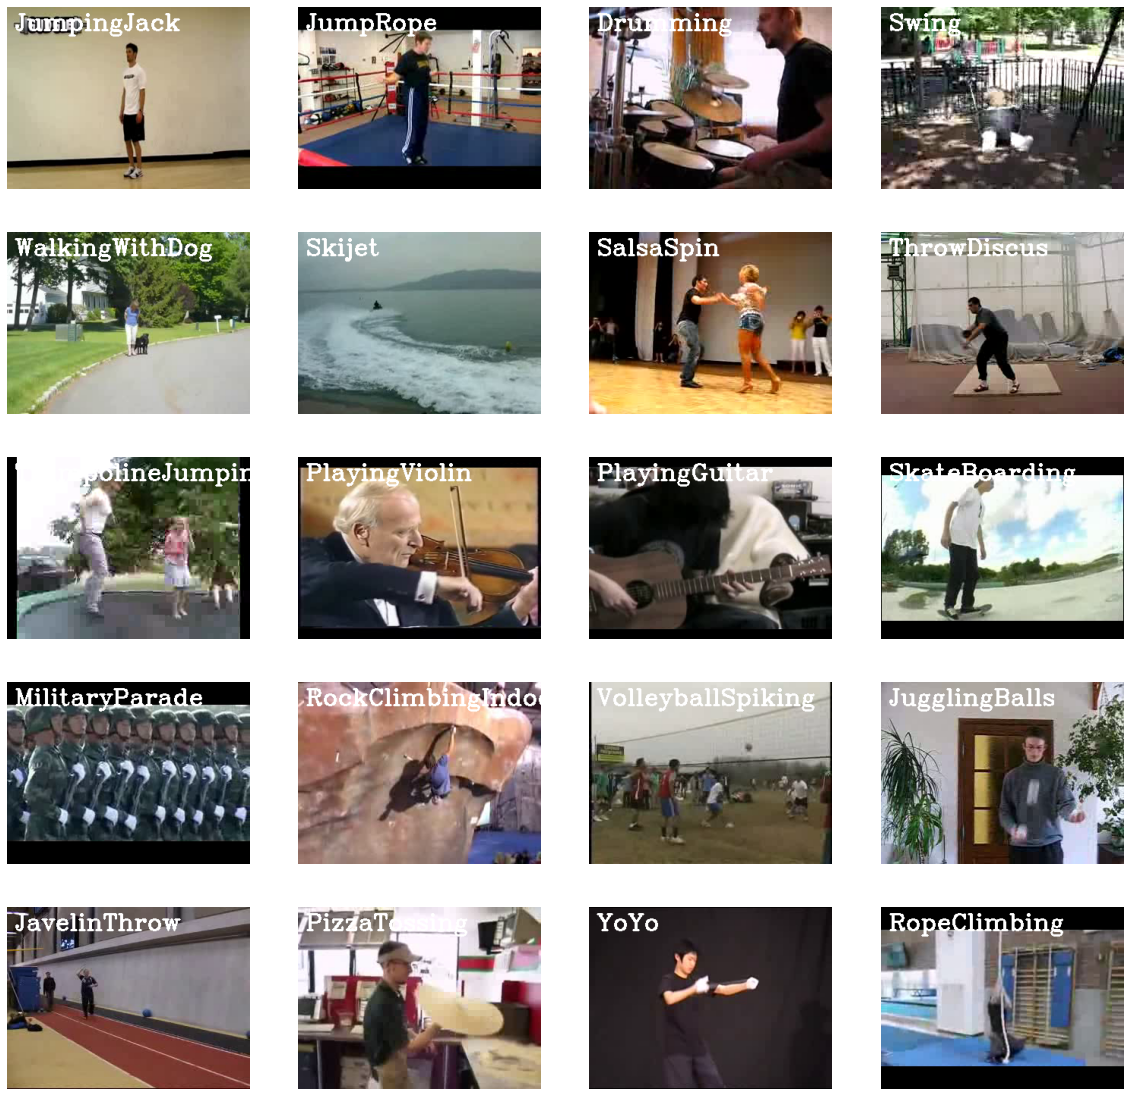

In [ ]:
plt.figure(figsize=(20,20))
# get names of the classes from the dataset
all_classes_names = os.listdir('/content/UCF50')
# Get 20 random classes from the 50 classes dataset
random_range = random.sample(range(len(all_classes_names)), 20)
# Iterating through all the genrated random values
for counter, random_index in enumerate(random_range, 1):
  # Retrive a class name using the random Index
  selected_class_Name = all_classes_names[random_index]
  # Retrive the list of all the video files present in the randomly selected class Directory
  video_files_names_list =  os.listdir(f'/content/UCF50/{selected_class_Name}')

  # Randomly select a video file from the list retrived from the randomly selected class Directory
  selected_video_file_name = random.choice(video_files_names_list)

  # Initialize a VideoCapture object to read from the video files
  video_reader = cv2.VideoCapture(f'/content/UCF50/{selected_class_Name}/{selected_video_file_name}')

  # Read the first frame of the vaideo file
  _, bgr_frame = video_reader.read()
  # Release the videoCapture object
  video_reader.release()

  # Convert the frame from BGR to RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
  # Display the frame
  plt.subplot(5, 4, counter);
  plt.imshow(rgb_frame);
  plt.axis('off')


# Preprocessing Data

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
# Specify the number of frames of a video that will be fed to tbe mdel as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset
DATASET_DIR  = 'UCF50'

# Specify the list containing the names of the classes used for training .
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
def frames_extraction(video_path):
    """
    this function will extract the required frames form a video after resizing and normalizing them.
    Args:
      Video_path: the path of the video in the dist, whose frames are to be extracted.  
    Returns:
      Frames_list: A list containing the resized and normalized frames of the video
      """
    # Declare a list to store video frames
    frames_list = []
    # Read the Video File using the VideooCapture object.
    video_reader = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    #Iterate through the video frames
    for frame_counter in range(SEQUENCE_LENGTH):
      # Set the current frame position of the video
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
      # Reading the frame from the video.
      success, frame = video_reader.read()

      # Chekc if video fraem in not successfully read the break the loop
      if not skip_frames_window:
        break
      
      #Resize the Frame to fixed height and width 
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT,IMAGE_WIDTH))

      # Normalize the resized frame by dividing it with 255 so that each pixel values then lies between 0 and 1
      normalized_frame =  resized_frame/255

      # Append the normalized frame into the frames list
      frames_list.append(normalized_frame)
    
    # Release the VideoCapture object
    video_reader.release()

    # retur the frame list
    return frames_list


# Dataset Creation

In [ ]:
def create_dataset():
  """
  This function will extract the data of the selected classes and create the required dataset
  Returns:
    Features: A list containing the extracted frames of the videos.
    labels:   A list containing the indexes of the classes associated with the videos.
    Video_files_paths: A list containing the paths of the videos in the dist. 
  """
  # Declared Empty Lists to store the features , labels and video file path
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):
    #Display the name of the class whose data is being extracted
    print(f'Extracting Data of Class : {class_name}') 
    # Get the list of video files present in the specific class name directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    # Iterate through all the files present in the files list.

    for file_name in files_list:
      # Get the complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # Extract the frames of the video file.
      frames = frames_extraction(video_file_path)
      
      # Check if the extracted frames are equal to the sequence_length specified above.
      # So ignore the videos have frames less than the Sequence_lenght.
      if len(frames) == SEQUENCE_LENGTH:
        # Append the data to their respective lists.
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # Converting the list to numpy arrays
  featrures = np.asarray(features)
  labels = np.array(labels)

  # Return the frames, class index and video file path.
  return features, labels, video_files_paths
  

In [ ]:
# Create Dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class : WalkingWithDog
Extracting Data of Class : TaiChi
Extracting Data of Class : Swing
Extracting Data of Class : HorseRace


In [ ]:
from tensorflow.keras.utils import to_categorical
one_hot_encoded_labels = to_categorical(labels)

# Split Data into Train and Test set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

# Contruct Model

In [ ]:
def create_convlstm_model():

  model  = Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation='tanh',
              data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, 
              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT,
                           IMAGE_WIDTH,3)))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation='tanh',
              data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', 
                         data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation='tanh',
              data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', 
                         data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation='tanh',
              data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', 
                         data_format='channels_last'))
  # model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))
  # Display summary of model
  model.summary()
  # Return the constructed convlstm model.
  return model
  

In [ ]:
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

# Model Structure

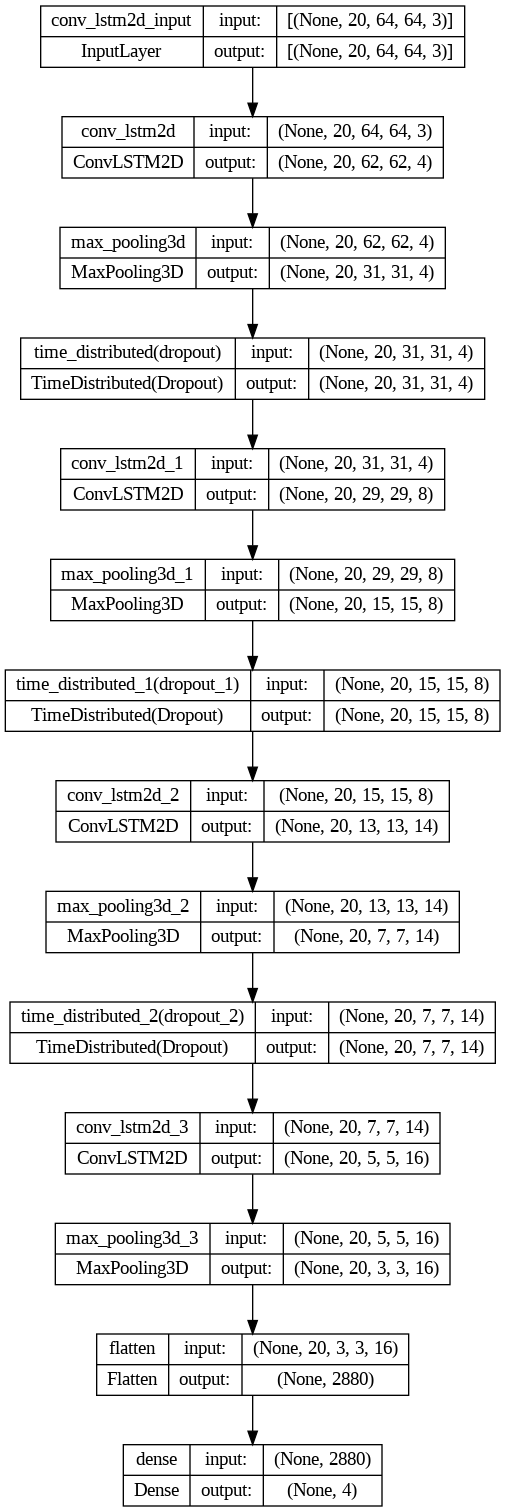

In [ ]:
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png', 
          show_shapes=True, show_layer_names=True)

# Compile and Train Model

In [ ]:
import numpy as np
features_train = np.array(features_train)
features_train = features_train.reshape(-1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10,
                             mode='min',restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam',
                      metrics=["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x=features_train,
          y= labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 42s 312ms/step - loss: 1.3483 - accuracy: 0.3527 - val_loss: 1.3367 - val_accuracy: 0.3836
Epoch 2/50
73/73 [==============================] - 23s 318ms/step - loss: 1.1800 - accuracy: 0.4897 - val_loss: 1.2861 - val_accuracy: 0.3562
Epoch 3/50
73/73 [==============================] - 22s 305ms/step - loss: 1.0951 - accuracy: 0.5548 - val_loss: 1.2279 - val_accuracy: 0.4658
Epoch 4/50
73/73 [==============================] - 23s 311ms/step - loss: 0.9080 - accuracy: 0.6404 - val_loss: 1.1334 - val_accuracy: 0.4658
Epoch 5/50
73/73 [==============================] - 23s 312ms/step - loss: 0.7660 - accuracy: 0.6952 - val_loss: 0.8962 - val_accuracy: 0.6849
Epoch 6/50
73/73 [==============================] - 21s 282ms/step - loss: 0.6555 - accuracy: 0.7158 - val_loss: 0.7832 - val_accuracy: 0.7260
Epoch 7/50
73/73 [==============================] - 21s 291ms/step - loss: 0.4778 - accuracy: 0.7911 - val_loss: 0.7301 - val_accuracy: 0.6438

# Evaluate The Trained Model

In [ ]:
print(labels_test.shape)
features_test = np.array(features_test)
features_test = features_test.reshape(-1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
# print(features_test)
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

(122, 4)
4/4 [==============================] - 1s 113ms/step - loss: 0.8350 - accuracy: 0.7377


# Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_hestory
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the String date formate
# Get the current date and time in a DateTime Object
# Convert the DateTime object to String according to the style mentioned in the date_formate string

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us white navigating through multiple saved models
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)

# Plot model's Loss & Accuracy Curves

In [ ]:
def plot_metrics(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  this function will plot the metrics passed to it in a graph.
  Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
  '''


  # Get metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # construct  a range object which will be used as x-axis (horizontal plane) of the graph
  epochs = range(len(metric_value_1))
  # plot the graph
  plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

  # Add title to the plot
  plt.title(str(plot_name))

  # Add legend to the plot.
  plt.legend()



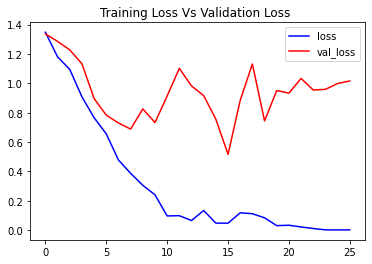

In [ ]:
# Visualize the training and validation loss, metrics
plot_metrics(convlstm_model_training_history, 'loss', 'val_loss', 'Training Loss Vs Validation Loss ')

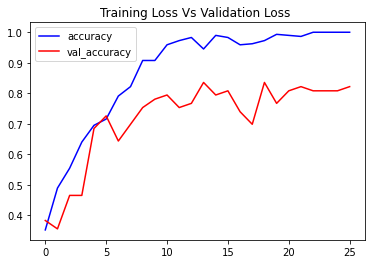

In [ ]:
# Visulize the training and validation accuracy, metrics
plot_metrics(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Training Loss Vs Validation Loss ')

4/4 [==============================] - 1s 162ms/step


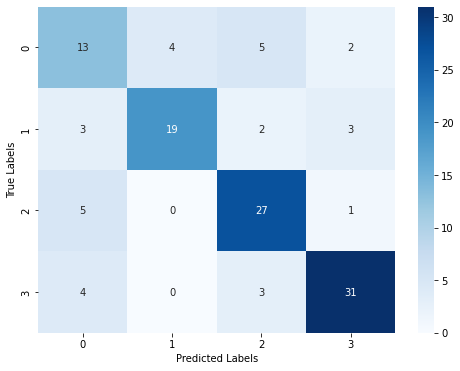

In [ ]:
# import necessary libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# get predicted and true labels
features_test = np.array(features_test)
features_test = features_test.reshape(-1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
y_pred = convlstm_model.predict(features_test)
y_true = labels_test

# convert multilabel-indicator targets to multiclass targets
y_true = np.argmax(y_true, axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred.argmax(axis=1))

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Build LRCN Model

In [ ]:
def create_LRCN_Model():
  """This function will construct the required LRCN Model.
  Returns:
    Mode : It is the required constructed LRCN model.
  """
  # we will use a Sequential model for model construction
  model = Sequential()

  # Define the Model Architecture.

  # #########################################################

  model.add(TimeDistributed(Conv2D(16,(3,3), padding='same', activation='relu'),
                            input_shape= (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding='same', activation='relu'),))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding='same', activation='relu'),))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding='same', activation='relu'),))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  # Display the models summary.
  model.summary()

  # Return the constructed LRCN model.
  return model





In [ ]:
# Construct the required LRCN model.

LRCN_model = create_LRCN_Model()

# Display the success message
print("Model Created Successfully!")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 4, 4, 32)    

# Model Stucture

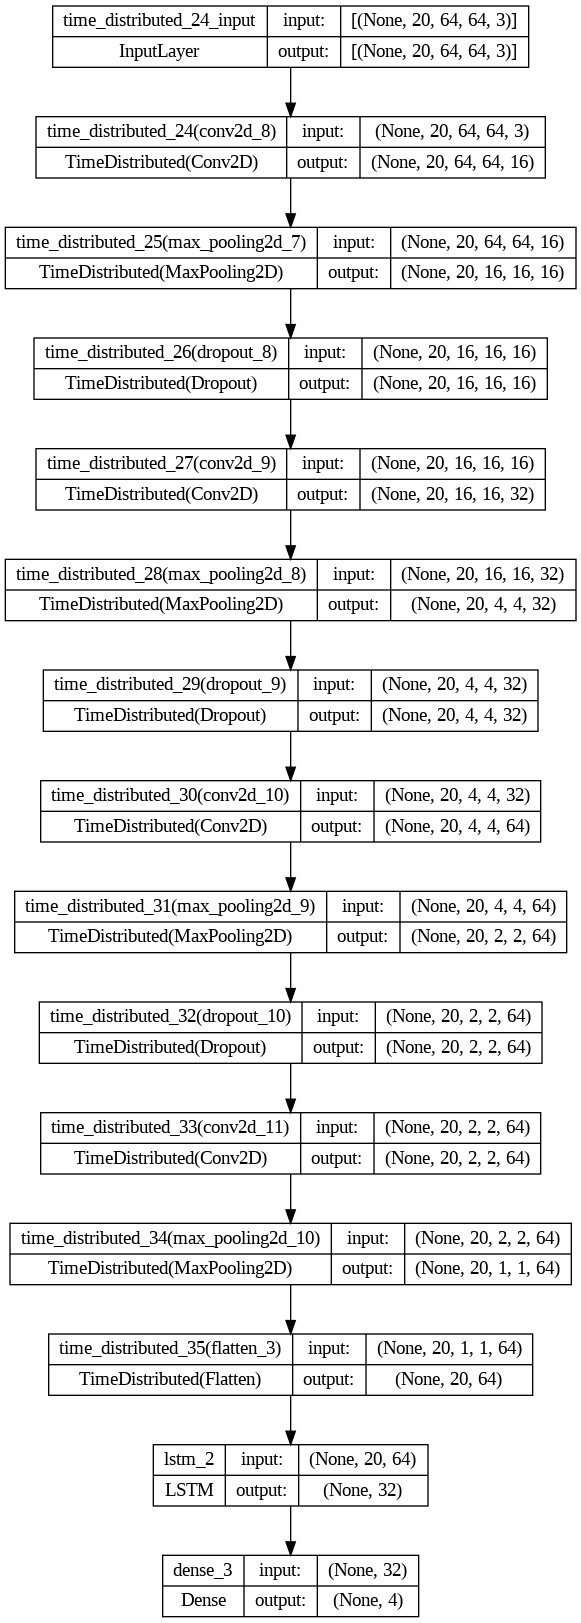

In [ ]:
# plot_model(LRCN_model, to_file='LRCN_model_structure_plot.png', show_shapes=True, show_layer_names=True)
plot_model(LRCN_model, to_file='LRCN_model_structure_plot.png', show_shapes=True, show_layer_names=True)

# Compile and Train the Model

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=15, mode='min', restore_best_weights=True)
# Compile the model and specify loss function, optimizer and metrics to the model
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Strat training the model
LRCN_model_training_histroy = LRCN_model.fit(x=features_train, y=labels_train,
    epochs=70, batch_size=4, shuffle=True, validation_split=0.2, 
    callbacks=[early_stopping_callback])


Epoch 1/70
73/73 [==============================] - 5s 21ms/step - loss: 1.3922 - accuracy: 0.2705 - val_loss: 1.3616 - val_accuracy: 0.3562
Epoch 2/70
73/73 [==============================] - 1s 12ms/step - loss: 1.3306 - accuracy: 0.3630 - val_loss: 1.2977 - val_accuracy: 0.4932
Epoch 3/70
73/73 [==============================] - 1s 11ms/step - loss: 1.2186 - accuracy: 0.4692 - val_loss: 1.3518 - val_accuracy: 0.3014
Epoch 4/70
73/73 [==============================] - 1s 11ms/step - loss: 1.1882 - accuracy: 0.5034 - val_loss: 1.3531 - val_accuracy: 0.3151
Epoch 5/70
73/73 [==============================] - 1s 15ms/step - loss: 1.0607 - accuracy: 0.5993 - val_loss: 1.2423 - val_accuracy: 0.4110
Epoch 6/70
73/73 [==============================] - 1s 15ms/step - loss: 0.9406 - accuracy: 0.6199 - val_loss: 1.3378 - val_accuracy: 0.3973
Epoch 7/70
73/73 [==============================] - 1s 10ms/step - loss: 0.8391 - accuracy: 0.6712 - val_loss: 0.9744 - val_accuracy: 0.6164
Epoch 8/70
73

# Evaluating the Trained Model

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 0s 24ms/step - loss: 0.5573 - accuracy: 0.8361


# Save Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date fromate.
# Get the current Date and Time in a DateTime Object
# Convert the DateTime object to string accroding to the style mentioned and date_format
date_time_format = '%Y_%m_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()

current_date_time_dt = dt.datetime.strftime(current_date_time_dt, date_time_format)
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss:.2f}___Accuracy_{model_evaluation_accuracy:.2f}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

# Plot Model's Loss and Accuracy Curves

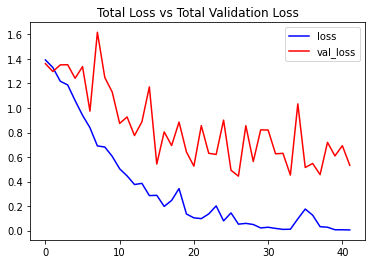

In [ ]:
# Visualize the training and validation loss metrices.
plot_metrics(LRCN_model_training_histroy, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

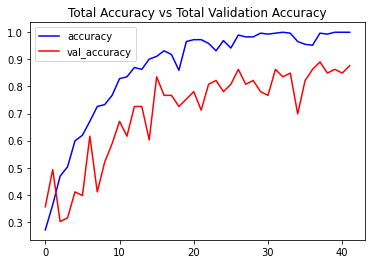

In [ ]:
.

# Download youtube video

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
# Download a YouTube Video.
# video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)
 
# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'/content/test_videos/Test Video.mp4'

# Perform Action Recognition on Videos

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

# Perform Action Recognition on Test Video

In [ ]:
from moviepy  import *
# Construct the output video path.
output_video_file_path = f'/content/test_videos/TestVideo.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
 
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  98%|█████████▊| 848/869 [00:04<00:00, 228.25it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.9/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test_videos/TestVideo.mp4, 360000 bytes wanted but 0 bytes read,at frame 866/869, at time 31.04/31.12 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
from moviepy.editor import VideoFileClip

# Load the video file
# Construct the output video path.
output_video_file_path = f'/content/test_videos/TestVideo.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
clip = VideoFileClip(output_video_file_path)

# Get the duration of the video in seconds
duration = clip.duration

print("Duration:", duration)

Duration: 31.12
